In [65]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import pickle

# Implementing ResNet in PyTorch
Today we are going to implement the famous ResNet from Kaiming He et al. (Microsoft Research). It won the 1st place on the ILSVRC 2015 classification task.

The original paper can be read from [here ](https://arxiv.org/abs/1512.03385) and it is very easy to follow, additional material can be found in this [quora answer](https://www.quora.com/)
![alt](./images/custom/rotated-resnet34.png)

*Deeper neural networks are more difficult to train.* Why? One big problem of deeper network is the vanishing gradient. Basically, the model is not able to learn anymore.

To solve this problem, the Authors proposed to use a reference to the previous layer to compute the output at a given layer. In ResNet, the output form the previous layer, called **residual**, is added to the output of the current layer. The following picture visualizes this operation

![alt](./images/residual.png)

We are going to make our implementation **as scalable as possible** using one think think unknown to mostly of the data scientiest: **object orienting programming**

## Basic Block

Okay, the first thing is to think about what we need. Well, first of all we need a convolution layer and since PyTorch does not have the 'auto' padding in Conv2d, so we have to code ourself!

In [2]:
class Conv2dAuto(nn.Conv3d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2, self.kernel_size[2] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      
        

In [3]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)


## Residual Block
To make clean code is mandatory to think about the main building block of each application, or of the network in our case. The residual block takes an input with `in_channels`, applies some blocks of convolutional layers to reduce it to `out_channels` and sum it up to the original input. If their sizes mismatch, then the input goes into an `identity`. We can abstract this process and create a interface that can be extedend.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [5]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Identity()
)

Let's test it with a dummy vector with one one, we should get a vector with two

In [6]:
dummy = torch.ones((1, 1, 1, 1))

block = ResidualBlock(1, 64)
block(dummy)

tensor([[[[2.]]]])

In ResNet each block has a expansion parameter in order to increase the `out_channels`. Also, the identity is defined as a Convolution followed by an Activation layer, this is referred as `shortcut`. Then, we can just extend `ResidualBlock` and defined the `shortcut` function.

In [7]:
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv3d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm3d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [8]:
ResNetResidualBlock(32, 64)

ResNetResidualBlock(
  (blocks): Identity()
  (shortcut): Sequential(
    (conv): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### Basic Block
A basic ResNet block is composed by two layers of `3x3` convs/batchnorm/relu. In the picture, the lines represnet the residual operation. The dotted line means that the shortcut was applied to match the input and the output dimension.
![alt](./images/custom/Block.png)

Let's first create an handy function to stack one conv and batchnorm layer. Using `OrderedDict` to properly name each sublayer.

In [9]:
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm3d(out_channels) }))

In [10]:
conv_bn(3, 3, nn.Conv3d, kernel_size=3)

Sequential(
  (conv): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (bn): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    

In [12]:
dummy = torch.ones((1, 80, 80, 10, 1))

block = ResNetBasicBlock(80, 64)
block(dummy).shape
print(block)

ResNetBasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(80, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv3d(80, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### BottleNeck
To increase the network deepths but to decrese the number of parameters, the Authors defined a BottleNeck block that 
"The three layers are 1x1, 3x3, and 1x1 convolutions, where the 1×1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3×3 layer a bottleneck with smaller input/output dimensions." We can extend the `ResNetResidualBlock` and create these blocks.

In [13]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
    

In [14]:
dummy = torch.ones((1, 32, 10, 10, 1))

block = ResNetBottleNeckBlock(32, 64)
block(dummy).shape
print(block)

ResNetBottleNeckBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (conv): Conv2dAuto(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv3d(32, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### Layer
A ResNet's layer is composed by blocks stacked one after the other. 

![alt](./images/custom/Layer.png)

We can easily defined it by just stuck `n` blocks one after the other, just remember that the first convolution block has a stide of two since "We perform downsampling directly by convolutional layers that have a stride of 2".

In [15]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [16]:
dummy = torch.ones((1, 32, 48, 48, 1))

layer = ResNetLayer(64, 128, block=ResNetBasicBlock, n=3)
# layer(dummy).shape
layer

ResNetLayer(
  (blocks): Sequential(
    (0): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequential(
        (conv): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1,

### Encoder
Similarly, the encoder is composed by multiple layer at increasing features size.

![alt](./images/custom/rotated-Encoder.png)



In [17]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv3d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

## Decoder
The decoder is the last piece we need to create the full network. It is a fully connected layer that maps the features learned by the network to their respective classes. Easily, we can defined it as:

In [18]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


In [19]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, h1, h2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1).to(device)
        #self.bn1 = nn.BatchNorm1d(h1_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(h1, h2).to(device)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        
        self.fc6 = nn.Linear(h2, num_classes).to(device)
    
    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        """
        #out = self.bn2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        #out = self.bn3(out)
        
        out = self.fc4(out)
        #out = self.bn4(out)
        out = self.relu4(out)
        out = self.drop4(out)
        
        #out = self.bn4(out)
        out = self.fc5(out)
        #out = self.bn5(out)
        out = self.relu5(out)
        out = self.drop5(out)
        """
        out = self.fc6(out)
        return out

## ResNet

Final, we can put all the pieces together and create the final model.

![alt](./images/custom/rotated-resnet34.png)

In [20]:
class ResNet3(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder1 = ResNetEncoder(in_channels, *args, **kwargs).to(device)
        self.decoder1 = ResnetDecoder(self.encoder1.blocks[-1].blocks[-1].expanded_channels, n_classes).to(device)
        self.encoder2 = ResNetEncoder(in_channels, *args, **kwargs).to(device)
        self.decoder2 = ResnetDecoder(self.encoder2.blocks[-1].blocks[-1].expanded_channels, n_classes).to(device)
        self.encoder3 = ResNetEncoder(in_channels, *args, **kwargs).to(device)
        self.decoder3 = ResnetDecoder(self.encoder3.blocks[-1].blocks[-1].expanded_channels, n_classes).to(device)
        
        self.layers_nn = NeuralNet(6, 16, 8, 2).to(device)
        
        self.usr_nn = NeuralNet(11, 16, 8, 2).to(device)
        self.final_nn = NeuralNet(4, 8, 4, 2).to(device)
        
    def forward(self, x, y):
        l1 = x[:,:,:,:,0][:,:,:,:,None]
        l2 = x[:,:,:,:,1][:,:,:,:,None]
        l3 = x[:,:,:,:,2][:,:,:,:,None]
        
        x1 = self.encoder1(l1)
        x1 = self.decoder1(x1)
        x2 = self.encoder2(l2)
        x2 = self.decoder2(x2)
        x3 = self.encoder3(l3)
        x3 = self.decoder3(x3)
        
        xs = torch.cat((x1, x2, x3), dim=1)
        xs = self.layers_nn(xs)
        
        y = self.usr_nn(y)
        z = torch.cat((xs, y), dim=1)
        
        z = self.final_nn(z)
        return z

In [21]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs).to(device)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes).to(device)

        self.usr_nn = NeuralNet(11, 16, 8, 2).to(device)
        self.final_nn = NeuralNet(4, 8, 4, 2).to(device)
        
    def forward(self, x, y):
        x = self.encoder(x)
        x = self.decoder(x)
        
        y = self.usr_nn(y)
        z = torch.cat((x, y), dim=1)
        
        z = self.final_nn(z)
        return z

We can now defined the five models proposed by the Authors, `resnet18,34,50,101,152`

In [22]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [35]:
from torchviz import make_dot

rn = resnet34(10, 2)
dum_input1 = torch.ones(1,10,80,80,3).to(device)
dum_input2 = torch.ones(1, 11).to(device)
outputs = rn(dum_input1, dum_input2)
make_dot(outputs, params=dict(rn.named_parameters())).render(f"{DATA_DIR}/viz/resnet34",format="png")

'/media/hwixley/data-drive/mlp-coursework3/stoic-preprocess/ResNet-master/../../data2/slices/viz/resnet34.png'

In [23]:
from torchsummary import summary

model = resnet18(70, 2)
summary(model.cuda(), (3, 224, 224))

NameError: name 'device' is not defined

In [24]:
import torchvision.models as models

# resnet101(False)

summary(models.resnet18(False).cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [40]:
import os
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [41]:
DATA_DIR = f"{os.getcwd()}/../../data2/slices/"

In [42]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
def loadNpy(filename):
    with open(filename, "rb") as f: return np.load(f)

db = f"{os.getcwd()}/../../data2/slices/gaussian-grabber/size192000-hwDiv0.75-dDiv0.5/"
data_type = "s-"

In [44]:
X_im_train, X_im_val, X_im_test = loadNpy(db + f"X_image_train.npy"), loadNpy(db + f"X_image_val.npy"), loadNpy(db + f"X_image_test.npy")
X_usr_train, X_usr_val, X_usr_test = loadNpy(db + f"X_usr_train.npy"), loadNpy(db + f"X_usr_val.npy"), loadNpy(db + f"X_usr_test.npy")

y_train, y_val, y_test = loadNpy(db + f"{data_type}y_train.npy"), loadNpy(db + f"{data_type}y_val.npy"), loadNpy(db + f"{data_type}y_test.npy")

In [48]:
X_train, X_val, X_test = loadNpy(db + f"X_train.npy"), loadNpy(db + f"X_val.npy"), loadNpy(db + f"X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"{data_type}y_train.npy"), loadNpy(db + f"{data_type}y_val.npy"), loadNpy(db + f"{data_type}y_test.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/media/hwixley/data-drive/mlp-coursework3/stoic-preprocess/ResNet-master/../../data2/slices/gaussian-grabber/size192000-hwDiv0.75-dDiv0.5/X_train.npy'

In [49]:
minAcc = (np.sum(y_train.numpy()) + np.sum(y_val.numpy()) + np.sum(y_test.numpy()))/1962
print(minAcc)

0.15086646279306828


In [47]:
y_train

tensor([0, 0, 0,  ..., 0, 0, 0])

In [45]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [46]:
X_img_train, X_img_val, X_img_test = npy_to_tensor(X_im_train), npy_to_tensor(X_im_val), npy_to_tensor(X_im_test)
X_usr_train, X_usr_val, X_usr_test = npy_to_tensor(X_usr_train), npy_to_tensor(X_usr_val), npy_to_tensor(X_usr_test)

y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [28]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [51]:
batch_size = 32

In [52]:
train_iterator = DataLoader(dataset=TensorDataset(X_img_train, X_usr_train, y_train),batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=TensorDataset(X_img_val, X_usr_val, y_val), batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=TensorDataset(X_img_test, X_usr_test, y_test), batch_size=batch_size,shuffle=False)

In [30]:
train_dataset = TensorDataset(X_train, y_train)

val_dataset = TensorDataset(X_val, y_val)

test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_iterator = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [148]:
X_train.shape

NameError: name 'X_train' is not defined

In [53]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [54]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD

In [55]:
import torch.optim as optim

In [56]:
imratio = minAcc
SEED = 123
BATCH_SIZE = 64
lr =  1e-2
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

In [85]:
rn = resnet18(3, 2)#.to(device)
torch.manual_seed(SEED)

In [86]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(rn.parameters(), lr = 0.01, weight_decay=1e-4)
sched_type = ""

In [58]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn.parameters(), lr = 0.01, weight_decay=1e-4, momentum=0.5) 

In [42]:
loss_func = AUCMLoss(imratio=imratio)
loss_func

AUCMLoss()

In [43]:
optimizer = PESG(rn, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay) #optim.Adam(rn.parameters(), lr = 0.0001, weight_decay=5e-2)   
optimizer

PESG (
Parameter Group 0
    a: tensor([0.], device='cuda:0', requires_grad=True)
    alpha: tensor([0.], device='cuda:0', requires_grad=True)
    b: tensor([0.], device='cuda:0', requires_grad=True)
    clip_value: 1.0
    gamma: 0.99
    lr: 0.01
    margin: 0.6
    model_acc: [tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.

In [48]:
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80,120,170,220,270], gamma=0.1)
sched_type = "12"

In [59]:
swa_model = torch.optim.swa_utils.AveragedModel(rn)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
swa_start = 160
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
sched_type = "swa"

In [59]:
from sklearn.metrics import roc_auc_score

In [ ]:
num_epochs = 500
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in range(num_epochs):
    nn_epochs[epoch] = {}
    
    for phase in ["train", "val", "test"]:
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        losses = []
        
        if phase == "train":
            #optimizer = scheduler(optimizer, epoch)
            rn.train(True)
        else:
            rn.train(False)
            rn.eval()
    
        for i, (images, users, labels) in enumerate(loaders[phase]): 
            images = torch.swapaxes(images, 1, 4)
            images = images.to(device)
            users = users.to(device)

            labels = labels.to(device)

            # Forward pass
            #print(images.shape)
            outputs = rn(images, users)
            pred_y = torch.max(outputs, 1)[1].data.squeeze()
            #print(outputs.shape)
            #print(labels.shape)
            #pred_y = torch.max(outputs, 1)[1].data.squeeze()
            loss = loss_func(outputs, labels)
            losses.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()

            if phase == "train":
                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step() 


            #print(pred_y)
            pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, total_step, np.mean(losses)))

        print(f'{phase} accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")

        #nn_epochs[epoch] = {}
        nn_epochs[epoch][phase] = {"loss": np.mean(losses), "acc": correct/total, 
                                 "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                                "auc": roc_auc_score(labs, pred_ys)}
        
    print()
    if sched_type == "swa":
        if epoch > swa_start:
            swa_model.update_parameters(rn)
            swa_scheduler.step()
        else:
            scheduler.step()
    elif sched_type == "12":         
        scheduler1.step()
        scheduler2.step()
    
    if epoch+1 % 100 == 0:
        with open(f"{db}ep{epoch+1}-resnet50-3channels.pickle", "ab") as f:
            pickle.dump(nn_epochs, f)

Epoch [1/500], Step [37/37], Loss: 0.5306
train accuracy of the model on the 1176 images: 0.801
Sensitivity = 0.078125
Specificity = 0.9420731707317073
AUC = 0.5100990853658537
Epoch [1/500], Step [13/37], Loss: 0.4443
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [1/500], Step [13/37], Loss: 0.4385
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [2/500], Step [37/37], Loss: 0.4370
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [2/500], Step [13/37], Loss: 0.4147
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [2/500], Step [13/37], Loss: 0.4134
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [3/500], Step [37/37], Loss: 0.4323
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specifi

Epoch [20/500], Step [37/37], Loss: 0.4197
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [20/500], Step [13/37], Loss: 0.4368
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [20/500], Step [13/37], Loss: 0.4200
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [21/500], Step [37/37], Loss: 0.4202
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [21/500], Step [13/37], Loss: 0.4972
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [21/500], Step [13/37], Loss: 0.4818
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [22/500], Step [37/37], Loss: 0.4185
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [

Epoch [39/500], Step [13/37], Loss: 0.4500
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [39/500], Step [13/37], Loss: 0.4414
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [40/500], Step [37/37], Loss: 0.4199
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [40/500], Step [13/37], Loss: 0.4021
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [40/500], Step [13/37], Loss: 0.3901
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [41/500], Step [37/37], Loss: 0.4104
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [41/500], Step [13/37], Loss: 0.4695
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [41/

Epoch [58/500], Step [13/37], Loss: 0.4311
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [59/500], Step [37/37], Loss: 0.4130
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [59/500], Step [13/37], Loss: 0.4072
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [59/500], Step [13/37], Loss: 0.3868
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [60/500], Step [37/37], Loss: 0.4104
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [60/500], Step [13/37], Loss: 0.3919
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [60/500], Step [13/37], Loss: 0.3830
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [6

Epoch [78/500], Step [37/37], Loss: 0.4104
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [78/500], Step [13/37], Loss: 0.3880
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [78/500], Step [13/37], Loss: 0.3811
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [79/500], Step [37/37], Loss: 0.4004
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [79/500], Step [13/37], Loss: 0.4512
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [79/500], Step [13/37], Loss: 0.4247
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [80/500], Step [37/37], Loss: 0.4152
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [

Epoch [97/500], Step [13/37], Loss: 0.4047
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [97/500], Step [13/37], Loss: 0.3843
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [98/500], Step [37/37], Loss: 0.4130
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [98/500], Step [13/37], Loss: 0.3917
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [98/500], Step [13/37], Loss: 0.3913
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [99/500], Step [37/37], Loss: 0.4052
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [99/500], Step [13/37], Loss: 0.3956
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [99/

Epoch [116/500], Step [13/37], Loss: 0.3882
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [117/500], Step [37/37], Loss: 0.3902
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [117/500], Step [13/37], Loss: 0.4516
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [117/500], Step [13/37], Loss: 0.4107
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [118/500], Step [37/37], Loss: 0.3948
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [118/500], Step [13/37], Loss: 0.3893
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [118/500], Step [13/37], Loss: 0.3692
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

E

Epoch [136/500], Step [37/37], Loss: 0.3460
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [136/500], Step [13/37], Loss: 0.5143
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [136/500], Step [13/37], Loss: 0.5058
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [137/500], Step [37/37], Loss: 0.3572
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [137/500], Step [13/37], Loss: 0.4753
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [137/500], Step [13/37], Loss: 0.4548
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [138/500], Step [37/37], Loss: 0.3588
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5


Epoch [155/500], Step [13/37], Loss: 0.5261
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [155/500], Step [13/37], Loss: 0.5001
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [156/500], Step [37/37], Loss: 0.3110
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [156/500], Step [13/37], Loss: 0.5138
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [156/500], Step [13/37], Loss: 0.4804
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [157/500], Step [37/37], Loss: 0.3006
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [157/500], Step [13/37], Loss: 0.6947
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epo

Epoch [174/500], Step [13/37], Loss: 0.8005
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [175/500], Step [37/37], Loss: 0.2549
train accuracy of the model on the 1176 images: 0.823
Sensitivity = 0.515625
Specificity = 0.883130081300813
AUC = 0.6993775406504066
Epoch [175/500], Step [13/37], Loss: 0.5671
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [175/500], Step [13/37], Loss: 0.5772
test accuracy of the model on the 393 images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Epoch [176/500], Step [37/37], Loss: 0.2664
train accuracy of the model on the 1176 images: 0.837
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [176/500], Step [13/37], Loss: 0.5638
val accuracy of the model on the 393 images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [176/500], Step [13/37], Loss: 0.5507
test accuracy of the model on the 393 images: 0.878
Sensitivity = 

Epoch [191/500], Step [37/37], Loss: 0.1922
train accuracy of the model on the 1176 images: 0.913
Sensitivity = 0.8802083333333334
Specificity = 0.9197154471544715
AUC = 0.8999618902439025
Epoch [191/500], Step [13/37], Loss: 0.7558
val accuracy of the model on the 393 images: 0.651
Sensitivity = 0.5357142857142857
Specificity = 0.6706231454005934
AUC = 0.6031687155574397
Epoch [191/500], Step [13/37], Loss: 0.8605
test accuracy of the model on the 393 images: 0.669
Sensitivity = 0.4791666666666667
Specificity = 0.6956521739130435
AUC = 0.5874094202898551

Epoch [192/500], Step [37/37], Loss: 0.1901
train accuracy of the model on the 1176 images: 0.912
Sensitivity = 0.8854166666666666
Specificity = 0.9166666666666666
AUC = 0.9010416666666665
Epoch [192/500], Step [13/37], Loss: 0.9690
val accuracy of the model on the 393 images: 0.733
Sensitivity = 0.35714285714285715
Specificity = 0.7952522255192879
AUC = 0.5761975413310726
Epoch [192/500], Step [13/37], Loss: 0.9677
test accuracy of 

Epoch [206/500], Step [37/37], Loss: 0.1464
train accuracy of the model on the 1176 images: 0.934
Sensitivity = 0.9010416666666666
Specificity = 0.9400406504065041
AUC = 0.9205411585365854
Epoch [206/500], Step [13/37], Loss: 0.9561
val accuracy of the model on the 393 images: 0.578
Sensitivity = 0.5357142857142857
Specificity = 0.5845697329376854
AUC = 0.5601420093259856
Epoch [206/500], Step [13/37], Loss: 0.9154
test accuracy of the model on the 393 images: 0.618
Sensitivity = 0.4375
Specificity = 0.6434782608695652
AUC = 0.5404891304347826

Epoch [207/500], Step [37/37], Loss: 0.1397
train accuracy of the model on the 1176 images: 0.941
Sensitivity = 0.953125
Specificity = 0.9390243902439024
AUC = 0.9460746951219512
Epoch [207/500], Step [13/37], Loss: 1.0653
val accuracy of the model on the 393 images: 0.669
Sensitivity = 0.4642857142857143
Specificity = 0.7032640949554896
AUC = 0.583774904620602
Epoch [207/500], Step [13/37], Loss: 1.1251
test accuracy of the model on the 393 ima

Epoch [221/500], Step [37/37], Loss: 0.1203
train accuracy of the model on the 1176 images: 0.952
Sensitivity = 0.9583333333333334
Specificity = 0.9512195121951219
AUC = 0.9547764227642277
Epoch [221/500], Step [13/37], Loss: 1.0648
val accuracy of the model on the 393 images: 0.654
Sensitivity = 0.4107142857142857
Specificity = 0.6943620178041543
AUC = 0.5525381517592199
Epoch [221/500], Step [13/37], Loss: 1.2416
test accuracy of the model on the 393 images: 0.649
Sensitivity = 0.3333333333333333
Specificity = 0.6927536231884058
AUC = 0.5130434782608695

Epoch [222/500], Step [37/37], Loss: 0.1419
train accuracy of the model on the 1176 images: 0.942
Sensitivity = 0.9427083333333334
Specificity = 0.9420731707317073
AUC = 0.9423907520325204
Epoch [222/500], Step [13/37], Loss: 1.0659
val accuracy of the model on the 393 images: 0.639
Sensitivity = 0.625
Specificity = 0.6409495548961425
AUC = 0.6329747774480712
Epoch [222/500], Step [13/37], Loss: 1.2440
test accuracy of the model on t

Epoch [236/500], Step [37/37], Loss: 0.1791
train accuracy of the model on the 1176 images: 0.928
Sensitivity = 0.9166666666666666
Specificity = 0.9298780487804879
AUC = 0.9232723577235772
Epoch [236/500], Step [13/37], Loss: 1.0086
val accuracy of the model on the 393 images: 0.830
Sensitivity = 0.125
Specificity = 0.9465875370919882
AUC = 0.5357937685459941
Epoch [236/500], Step [13/37], Loss: 1.1683
test accuracy of the model on the 393 images: 0.850
Sensitivity = 0.0
Specificity = 0.9681159420289855
AUC = 0.48405797101449277

Epoch [237/500], Step [37/37], Loss: 0.1369
train accuracy of the model on the 1176 images: 0.945
Sensitivity = 0.921875
Specificity = 0.9491869918699187
AUC = 0.9355309959349594
Epoch [237/500], Step [13/37], Loss: 0.8939
val accuracy of the model on the 393 images: 0.662
Sensitivity = 0.4642857142857143
Specificity = 0.6943620178041543
AUC = 0.5793238660449344
Epoch [237/500], Step [13/37], Loss: 1.0959
test accuracy of the model on the 393 images: 0.667
Sen

Epoch [251/500], Step [37/37], Loss: 0.1136
train accuracy of the model on the 1176 images: 0.958
Sensitivity = 0.9270833333333334
Specificity = 0.9644308943089431
AUC = 0.9457571138211383
Epoch [251/500], Step [13/37], Loss: 1.6778
val accuracy of the model on the 393 images: 0.809
Sensitivity = 0.125
Specificity = 0.9228486646884273
AUC = 0.5239243323442137
Epoch [251/500], Step [13/37], Loss: 1.7378
test accuracy of the model on the 393 images: 0.847
Sensitivity = 0.08333333333333333
Specificity = 0.9536231884057971
AUC = 0.5184782608695652

Epoch [252/500], Step [37/37], Loss: 0.0878
train accuracy of the model on the 1176 images: 0.973
Sensitivity = 0.9739583333333334
Specificity = 0.9725609756097561
AUC = 0.9732596544715447
Epoch [252/500], Step [13/37], Loss: 1.6777
val accuracy of the model on the 393 images: 0.705
Sensitivity = 0.375
Specificity = 0.7596439169139466
AUC = 0.5673219584569733
Epoch [252/500], Step [13/37], Loss: 1.8168
test accuracy of the model on the 393 image

Epoch [266/500], Step [37/37], Loss: 0.0987
train accuracy of the model on the 1176 images: 0.965
Sensitivity = 0.9427083333333334
Specificity = 0.9695121951219512
AUC = 0.9561102642276423
Epoch [266/500], Step [13/37], Loss: 1.8641
val accuracy of the model on the 393 images: 0.768
Sensitivity = 0.4107142857142857
Specificity = 0.827893175074184
AUC = 0.6193037303942348
Epoch [266/500], Step [13/37], Loss: 2.1288
test accuracy of the model on the 393 images: 0.779
Sensitivity = 0.25
Specificity = 0.8521739130434782
AUC = 0.551086956521739

Epoch [267/500], Step [37/37], Loss: 0.0894
train accuracy of the model on the 1176 images: 0.969
Sensitivity = 0.953125
Specificity = 0.9725609756097561
AUC = 0.962842987804878
Epoch [267/500], Step [13/37], Loss: 1.8969
val accuracy of the model on the 393 images: 0.802
Sensitivity = 0.17857142857142858
Specificity = 0.9050445103857567
AUC = 0.5418079694785927
Epoch [267/500], Step [13/37], Loss: 2.1358
test accuracy of the model on the 393 images

Epoch [281/500], Step [37/37], Loss: 0.0426
train accuracy of the model on the 1176 images: 0.987
Sensitivity = 0.9947916666666666
Specificity = 0.9857723577235772
AUC = 0.9902820121951219
Epoch [281/500], Step [13/37], Loss: 2.1711
val accuracy of the model on the 393 images: 0.761
Sensitivity = 0.25
Specificity = 0.8456973293768546
AUC = 0.5478486646884273
Epoch [281/500], Step [13/37], Loss: 2.4469
test accuracy of the model on the 393 images: 0.779
Sensitivity = 0.14583333333333334
Specificity = 0.8666666666666667
AUC = 0.50625

Epoch [282/500], Step [37/37], Loss: 0.0469
train accuracy of the model on the 1176 images: 0.987
Sensitivity = 0.9947916666666666
Specificity = 0.9857723577235772
AUC = 0.9902820121951219
Epoch [282/500], Step [13/37], Loss: 3.4843
val accuracy of the model on the 393 images: 0.807
Sensitivity = 0.08928571428571429
Specificity = 0.9258160237388724
AUC = 0.5075508690122933
Epoch [282/500], Step [13/37], Loss: 4.0482
test accuracy of the model on the 393 ima

Epoch [296/500], Step [37/37], Loss: 0.0637
train accuracy of the model on the 1176 images: 0.976
Sensitivity = 0.9583333333333334
Specificity = 0.9796747967479674
AUC = 0.9690040650406505
Epoch [296/500], Step [13/37], Loss: 2.6671
val accuracy of the model on the 393 images: 0.771
Sensitivity = 0.19642857142857142
Specificity = 0.8664688427299704
AUC = 0.5314487070792708
Epoch [296/500], Step [13/37], Loss: 3.0888
test accuracy of the model on the 393 images: 0.799
Sensitivity = 0.10416666666666667
Specificity = 0.8956521739130435
AUC = 0.49990942028985513

Epoch [297/500], Step [37/37], Loss: 0.1052
train accuracy of the model on the 1176 images: 0.969
Sensitivity = 0.9479166666666666
Specificity = 0.9735772357723578
AUC = 0.9607469512195121
Epoch [297/500], Step [13/37], Loss: 1.4832
val accuracy of the model on the 393 images: 0.819
Sensitivity = 0.125
Specificity = 0.9347181008902077
AUC = 0.5298590504451038
Epoch [297/500], Step [13/37], Loss: 1.7808
test accuracy of the model o

Epoch [311/500], Step [37/37], Loss: 0.0714
train accuracy of the model on the 1176 images: 0.977
Sensitivity = 0.9635416666666666
Specificity = 0.9796747967479674
AUC = 0.971608231707317
Epoch [311/500], Step [13/37], Loss: 2.0363
val accuracy of the model on the 393 images: 0.700
Sensitivity = 0.32142857142857145
Specificity = 0.7626112759643917
AUC = 0.5420199236964816
Epoch [311/500], Step [13/37], Loss: 1.8492
test accuracy of the model on the 393 images: 0.738
Sensitivity = 0.22916666666666666
Specificity = 0.808695652173913
AUC = 0.5189311594202899

Epoch [312/500], Step [37/37], Loss: 0.0779
train accuracy of the model on the 1176 images: 0.974
Sensitivity = 0.953125
Specificity = 0.9786585365853658
AUC = 0.9658917682926829
Epoch [312/500], Step [13/37], Loss: 1.7388
val accuracy of the model on the 393 images: 0.779
Sensitivity = 0.25
Specificity = 0.8664688427299704
AUC = 0.5582344213649851
Epoch [312/500], Step [13/37], Loss: 1.7258
test accuracy of the model on the 393 imag

Epoch [326/500], Step [37/37], Loss: 0.0890
train accuracy of the model on the 1176 images: 0.972
Sensitivity = 0.9427083333333334
Specificity = 0.9776422764227642
AUC = 0.9601753048780489
Epoch [326/500], Step [13/37], Loss: 1.7926
val accuracy of the model on the 393 images: 0.771
Sensitivity = 0.30357142857142855
Specificity = 0.8486646884272997
AUC = 0.5761180584993641
Epoch [326/500], Step [13/37], Loss: 1.7449
test accuracy of the model on the 393 images: 0.791
Sensitivity = 0.16666666666666666
Specificity = 0.8782608695652174
AUC = 0.5224637681159421

Epoch [327/500], Step [37/37], Loss: 0.0568
train accuracy of the model on the 1176 images: 0.981
Sensitivity = 0.9791666666666666
Specificity = 0.9817073170731707
AUC = 0.9804369918699186
Epoch [327/500], Step [13/37], Loss: 2.2352
val accuracy of the model on the 393 images: 0.807
Sensitivity = 0.07142857142857142
Specificity = 0.9287833827893175
AUC = 0.5001059771089444
Epoch [327/500], Step [13/37], Loss: 2.3326
test accuracy o

Epoch [341/500], Step [37/37], Loss: 0.0295
train accuracy of the model on the 1176 images: 0.993
Sensitivity = 1.0
Specificity = 0.991869918699187
AUC = 0.9959349593495934
Epoch [341/500], Step [13/37], Loss: 3.5697
val accuracy of the model on the 393 images: 0.786
Sensitivity = 0.10714285714285714
Specificity = 0.8991097922848664
AUC = 0.5031263247138619
Epoch [341/500], Step [13/37], Loss: 3.9476
test accuracy of the model on the 393 images: 0.817
Sensitivity = 0.14583333333333334
Specificity = 0.9101449275362319
AUC = 0.5279891304347826

Epoch [342/500], Step [37/37], Loss: 0.0288
train accuracy of the model on the 1176 images: 0.993
Sensitivity = 1.0
Specificity = 0.991869918699187
AUC = 0.9959349593495934
Epoch [342/500], Step [13/37], Loss: 3.2946
val accuracy of the model on the 393 images: 0.768
Sensitivity = 0.17857142857142858
Specificity = 0.8664688427299704
AUC = 0.5225201356506994
Epoch [342/500], Step [13/37], Loss: 3.6509
test accuracy of the model on the 393 images: 0

Epoch [356/500], Step [13/37], Loss: 0.7517
val accuracy of the model on the 393 images: 0.705
Sensitivity = 0.2857142857142857
Specificity = 0.7744807121661721
AUC = 0.5300974989402288
Epoch [356/500], Step [13/37], Loss: 0.6513
test accuracy of the model on the 393 images: 0.761
Sensitivity = 0.2708333333333333
Specificity = 0.8289855072463768
AUC = 0.5499094202898549

Epoch [357/500], Step [37/37], Loss: 0.1349
train accuracy of the model on the 1176 images: 0.945
Sensitivity = 0.859375
Specificity = 0.9613821138211383
AUC = 0.9103785569105691
Epoch [357/500], Step [13/37], Loss: 1.6188
val accuracy of the model on the 393 images: 0.855
Sensitivity = 0.0
Specificity = 0.9970326409495549
AUC = 0.49851632047477745
Epoch [357/500], Step [13/37], Loss: 1.6032
test accuracy of the model on the 393 images: 0.875
Sensitivity = 0.0
Specificity = 0.9971014492753624
AUC = 0.4985507246376812

Epoch [358/500], Step [37/37], Loss: 0.0941
train accuracy of the model on the 1176 images: 0.969
Sens

Epoch [371/500], Step [13/37], Loss: 1.5973
val accuracy of the model on the 393 images: 0.812
Sensitivity = 0.125
Specificity = 0.9258160237388724
AUC = 0.5254080118694361
Epoch [371/500], Step [13/37], Loss: 1.5921
test accuracy of the model on the 393 images: 0.855
Sensitivity = 0.08333333333333333
Specificity = 0.9623188405797102
AUC = 0.5228260869565217

Epoch [372/500], Step [37/37], Loss: 0.0742
train accuracy of the model on the 1176 images: 0.976
Sensitivity = 0.9322916666666666
Specificity = 0.9847560975609756
AUC = 0.958523882113821
Epoch [372/500], Step [13/37], Loss: 1.4136
val accuracy of the model on the 393 images: 0.743
Sensitivity = 0.30357142857142855
Specificity = 0.8160237388724035
AUC = 0.559797583721916
Epoch [372/500], Step [13/37], Loss: 1.2819
test accuracy of the model on the 393 images: 0.771
Sensitivity = 0.20833333333333334
Specificity = 0.8492753623188406
AUC = 0.5288043478260869

Epoch [373/500], Step [37/37], Loss: 0.0689
train accuracy of the model on 

Epoch [386/500], Step [13/37], Loss: 1.6609
val accuracy of the model on the 393 images: 0.796
Sensitivity = 0.21428571428571427
Specificity = 0.8931750741839762
AUC = 0.5537303942348452
Epoch [386/500], Step [13/37], Loss: 1.6554
test accuracy of the model on the 393 images: 0.802
Sensitivity = 0.0625
Specificity = 0.9043478260869565
AUC = 0.48342391304347826

Epoch [387/500], Step [37/37], Loss: 0.0432
train accuracy of the model on the 1176 images: 0.987
Sensitivity = 0.9791666666666666
Specificity = 0.9888211382113821
AUC = 0.9839939024390243
Epoch [387/500], Step [13/37], Loss: 2.0081
val accuracy of the model on the 393 images: 0.807
Sensitivity = 0.17857142857142858
Specificity = 0.9109792284866469
AUC = 0.5447753285290378
Epoch [387/500], Step [13/37], Loss: 2.1282
test accuracy of the model on the 393 images: 0.840
Sensitivity = 0.08333333333333333
Specificity = 0.9449275362318841
AUC = 0.5141304347826088

Epoch [388/500], Step [37/37], Loss: 0.0537
train accuracy of the model

In [82]:
with open(f"{db}ep500-resnet50-3channels.pickle", "ab") as f:
    pickle.dump(nn_epochs, f)

In [72]:
import matplotlib.pyplot as plt

Text(0.5, 1, 'ResNet50 with 3 channels using an Adam Optimizer on Gaussian\nCompressed Volumes for Covid-19 Severity Diagnosis')

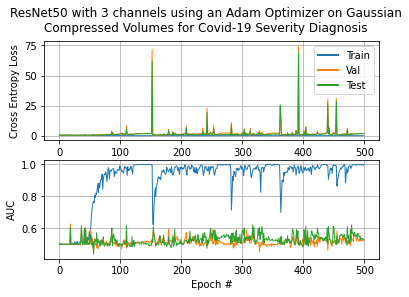

In [83]:
fig, axs = plt.subplots(2)

losses = getCNNdata(nn_epochs, "loss", 0, 500)
aucs = getCNNdata(nn_epochs, "auc", 0, 500)
lw = 1

axs[0].plot(np.arange(len(losses["train"])), losses["train"], label="Train", lw=lw)
axs[0].plot(np.arange(len(losses["val"])), losses["val"], label="Val", lw=lw)
axs[0].plot(np.arange(len(losses["test"])), losses["test"], label="Test", lw=lw)
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].grid(True)
#leg = axs[0].legend(loc="lower left")
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(2.0)
leg = axs[0].legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

axs[1].plot(np.arange(len(aucs["train"])), aucs["train"], label="Train", lw=lw)
axs[1].plot(np.arange(len(aucs["val"])), aucs["val"], label="Val", lw=lw)
axs[1].plot(np.arange(len(aucs["test"])), aucs["test"], label="Test", lw=lw)
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("AUC")
axs[1].grid(True)
#axs[1].legend(lw=1)

    
plt.suptitle("ResNet50 with 3 channels using an Adam Optimizer on Gaussian\nCompressed Volumes for Covid-19 Severity Diagnosis",y=1, fontsize=12)

In [74]:
losses = {"train": [], "val": [], "test": []}
aucs = {"train": [], "val": [], "test": []}

def getCNNdata(epochs, dtyp, epoch_start=0, epoch_end=1000):
    data = {"train": [], "val": [], "test": []}

    for epoch in range(epoch_start, epoch_end):
        for phase in epochs[epoch].keys():
            data[phase] = data[phase] + [epochs[epoch][phase][dtyp]]
            #aucs[phase] = aucs[phase] + [cnn_epochs[epoch][phase]["auc"]]
    return data

In [56]:
def eval_rn(rn_mod, data):
    
    loader = test_iterator
    if data == "train":
        loader = train_iterator
    elif data == "val":
        loader = val_iterator
    
    rn_mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loader:
            images = images.reshape(-1,1,451,540).to(device)
            labels = labels.to(device)
            #print(rn_mod(images))
            test_output = rn_mod(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            #print(pred_y)
            pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        
        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            cm[label, p] += 1
        
        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")
        
        return correct/total #, pred_ys #pred_ys, labs, correct/total
    pass

In [145]:
eval_rn(rn, "val")
eval_rn(rn, "test")

val Accuracy of the model on the 393 val images: 0.858
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
test Accuracy of the model on the 393 test images: 0.878
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5


0.8778625954198473

In [ ]:
num_epochs = 10
nn_epochs = {}

# Train the model
total_step = len(val_iterator)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(val_iterator):  
        # Move tensors to the configured device
        #print(images.shape)
        images = images.reshape(-1, 70, 70, 70).to(device)
        labels = labels.to(device)
        
        # Forward pass
        #print(images.shape)
        outputs = rn(images)
        pred_y = torch.max(outputs, 1)[1].data.squeeze()
        loss = loss_func(pred_y, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(i)

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    nn_epochs[epoch] = {"loss": loss.item(), #"train": eval_rn(rn, "train"), 
                 "val": eval_rn(rn, "val"), "test": eval_rn(rn, "test")}
    rn.train()